In [ ]:
#!pip install numpy==1.22.*
#!pip install queueing_tool

In [205]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import math
import itertools as it
from operator import itemgetter
from matplotlib import pyplot as plt, dates as md
from matplotlib.ticker import MaxNLocator
from scipy.special import factorial
from scipy.stats import norm, poisson, gamma, probplot, ks_2samp, kstest
from scipy.optimize import minimize, Bounds
from scipy.integrate import quad
from shapely.geometry import Point, Polygon

In [2]:
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12

In [3]:
def amostra_agrupada(df, grupo, tam, n_min, n_max, semente):
    df_filtrado = df.groupby(grupo).filter(lambda x: (len(x) >= n_min) & (len(x) <= n_max))
    amostra_df_filtrado = pd.Series(df_filtrado[grupo].unique()).sample(tam, random_state=semente)
    
    return df[df[grupo].isin(amostra_df_filtrado)]


def plot_agrupado(df, grupo, x, y, agr, cols):
    grps = df.groupby(grupo, sort=False)
    rows = int(grps.ngroups / cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))

    for (chv, grp), ax in zip(grps, axs.ravel()):
        grp.groupby(x).agg(pedidos=(y, agr)).plot(kind='bar', legend='', xlabel='', ax=ax)
        ax.set_title(grp[grupo].unique()[0])

In [4]:
def Y_t(x, T):
    return len(T[T >= x])


def epanechnikov(x):
    return 3 / 4 * (1 - x ** 2) if np.abs(x) <= 1 else np.zeros(1)

    
def alfa_t(x, T, b, K=norm.pdf):
    b = np.array([b]) if not isinstance(b, np.ndarray) else b
    n = len(T)
    K_t = [K((x - Ti) / b) / Y_t(Ti, T) for i, Ti in enumerate(T)]
    return np.sum(K_t) / b


def Lambda_t(x, T, b, K=norm.pdf):
    return alfa_t(x, T, b, K) * Y_t(x, T)


def A_t(x, T, b, K=norm.pdf):
    return quad(Lambda_t, 0, x, (T, b, K))


def A_t_parcial(xi, xj, T, b, K=norm.pdf):
    return quad(Lambda_t, xi, xj, (T, b, K))


def A_t_Riemann(T, b, K=norm.pdf, h=0.0001):
    oT = np.insert(np.sort(T), 0, 0)
    return oT[1:], h * np.cumsum([np.sum([Lambda_t(x, T, b, K) for x in np.arange(i, j, h)]) for i, j in zip(oT[:-1], oT[1:])])


def cv_loglike(b, x, K=norm.pdf):
    n = len(x)
    total_loglike = 0
    
    for i in range(n):
        x_sem_i = np.delete(x, i)
        xi = x[i]
        alfa_fxi = alfa_t(xi, x_sem_i, b, K)
        if alfa_fxi <= 0: continue
        total_loglike += np.log(alfa_fxi)
        
    return -total_loglike


def b_otimo_cv(f, ini, params, lims):
    return minimize(f, (ini,), params, bounds=lims)['x']

### Conjunto de dados

In [5]:
pedidos = pd.read_csv('./Dados/Amostra_Pedidos.csv', parse_dates=['Início Preparo', 'Início Entrega', 'Término Entrega'])

In [6]:
pedidos = pedidos[(pedidos['Início Preparo'] > dt.datetime(2023, 1, 10)) & (pedidos['Início Preparo'] < dt.datetime(2023, 1, 11))]

In [7]:
pedidos_por_estabelecimento = pedidos['Estabelecimento'].value_counts().reset_index()
estabelecimentos_validos = pedidos_por_estabelecimento[pedidos_por_estabelecimento['Estabelecimento'] >= 10]['index'].values
pedidos = pedidos[pedidos['Estabelecimento'].isin(estabelecimentos_validos)]

In [8]:
rest_grande = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 101, 200, 42)
rest_grande['Tam Rest'] = '100-200 orders'
rest_medio = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 51, 100, 42)
rest_medio['Tam Rest'] = '50-100 orders'
rest_pequeno = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 30, 50, 42)
rest_pequeno['Tam Rest'] = '30-50 orders'
amostra_rests = pd.concat([rest_pequeno, rest_medio, rest_grande])
amostra_rests['Horário Preparo'] = amostra_rests['Início Preparo'].dt.floor('1h').dt.strftime('%H:%M')

In [ ]:
plot_agrupado(amostra_rests, 'Tam Rest', 'Horário Preparo', 'Ident. Pedido', 'count', 3)

### Cálculos taxa de chegada

In [ ]:
grps = amostra_rests.groupby('Tam Rest', sort=False)
t0 = dt.datetime(2023, 1, 10)

Nt = []
for chv, grp in grps:
    T = (grp['Início Preparo'] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
    alfas_t = np.array([alfa_t(t, T, b) for t in T])
    As_t = A_t_Riemann(T, b)
    Nt.append({
        'Estab': chv,
        'b': b,
        'T': T,
        'alfa': alfas_t,
        'A': As_t
    })

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))

for N, ax in zip(Nt, axs.ravel()):
    ax.plot(N['A'][0], N['A'][1], label='Estimated')
    ax.plot(*list(zip(*np.array([(t, len(N['T'][N['T'] <= t])) for t in np.sort(N['T'])]))), label='Empirical')
    ax.set_title(N['Estab'])
    ax.legend()
    tks = ax.get_xticks()
    ax.set_xticklabels([(dt.datetime(2023, 1, 10) + dt.timedelta(seconds=int(t * 86400))).strftime('%H:%M') for t in tks])

In [ ]:
for N in Nt:
    emp = np.array([len(N['T'][N['T'] <= t]) for t in np.sort(N['T'])])
    est = N['A'][1]
    print(N['Estab'], round(ks_2samp(emp, est).pvalue, 4))

In [ ]:
pedidos_rests = pedidos.groupby('Estabelecimento').agg(pedidos_rest=('Ident. Pedido', 'count')).reset_index()
pedidos_rests['Tam Rest'] = pedidos_rests['pedidos_rest'].apply(lambda x: '>200' if x > 200 else '100-200' if x >= 100 else '50-100' if x >= 50 else '30-50' if x >=30 else '10-30')
pedidos = pedidos.merge(pedidos_rests, on='Estabelecimento')

In [ ]:
grps = pedidos.groupby('Estabelecimento')
NtT = []
for chv, grp in grps:
    print(chv)
    T = (grp['Início Preparo'] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, epanechnikov), Bounds(0.0001, float('inf')))
    As_t = A_t_Riemann(T, b)
    NtT.append({'Est': chv, 'Tam': grp['Tam Rest'].unique()[0], 'T': T, 'b': b, 'A': As_t})

import json

def conversor(x):
    if hasattr(x, 'tolist'):
        return x.tolist()
    raise TypeError(x)
    
with open('./temp_json', 'w') as arquivo:
    arquivo.write(json.dumps(NtT, indent=4, default=conversor))

In [ ]:
with open('./temp_json') as arquivo:
    NtT_json = np.array(json.loads(arquivo.read()))

In [ ]:
pvalues = []
for N in NtT:
    emp = np.array([len(N['T'][N['T'] <= t]) for t in np.sort(N['T'])])
    est = N['A'][1]
    pvalues.append({'Tam': N['Tam'], 'pvalue': ks_2samp(emp, est).pvalue})

In [ ]:
df_pvalues = pd.DataFrame(pvalues)
df_pvalues['c'] = 'c'

In [ ]:
df_pvalues.groupby('Tam').apply(lambda x: round((x.pvalue > 0.05).sum() / x.pvalue.count(), 4))

In [ ]:
def distancia(lat1, lon1, lat2, lon2):
    return math.acos(
        math.sin(math.radians(lat1)) * math.sin(math.radians(lat2)) + 
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(lon1) - math.radians(lon2))
    ) * 6371.

### Cálculo Tempos de Serviço

In [ ]:
pedidos['Distancia'] = pedidos.apply(lambda x: distancia(x['Lat Cliente'], x['Lon Cliente'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
def t0(d0, v0):
    return d0 / v0

In [ ]:
pdd_terc = pedidos[pedidos['Tipo Entrega'] == 'MERCHANT']

In [ ]:
pdd_terc['TP'] = 3
pdd_terc['Ttau'] = pdd_terc['Distancia'] / 25 * 60
pdd_terc['TC'] = pdd_terc['Ttau'] + pdd_terc['TP']
pdd_terc['d_TC'] = pdd_terc['TC'].apply(lambda x: math.floor(x)) + 1

In [ ]:
pdd_prim = pedidos[pedidos['Tipo Entrega'] == 'IFOOD']

In [ ]:
pdd_prim['TC'] = pdd_prim.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds()  / 60, axis=1)
pdd_prim['d_TC'] = pdd_prim.apply(lambda x: math.floor(x['TC']) + 1, axis=1)

In [ ]:
rests_cross = amostra_rests[['Tam Rest', 'Estabelecimento', 'Lat Estab.', 'Lon Estab.']].drop_duplicates().merge(pdd_prim[['Estabelecimento', 'Lat Estab.', 'Lon Estab.']].drop_duplicates(), how='cross')
rests_cross = rests_cross[rests_cross['Estabelecimento_x'] != rests_cross['Estabelecimento_y']]
rests_cross['distancia_rests'] = rests_cross.apply(lambda x: distancia(x['Lat Estab._x'], x['Lon Estab._x'], x['Lat Estab._y'], x['Lon Estab._y']), axis=1)
rests_proximos = rests_cross[rests_cross['distancia_rests'] <= 2]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = amostra_rests.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    #pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    #rest = grp['Estabelecimento'].unique()[0]
    a, l, b = gamma.fit(grp['TC'].values, floc=0)
    ax.hist(grp['TC'].values, bins=20, density=True)
    x = np.linspace(*grp['TC'].agg(['min', 'max']), 100)
    ax.plot(x, gamma.pdf(x, a, loc=0, scale=b))
    ax.set_title('{0}\nK: {1}, θ: {2}'.format(chv, round(a, 2), round(b, 2)))

In [ ]:
grp_estabs_prox = pdd_prim.groupby('Estabelecimento', sort=False)
pvals = []

for chv, grp in grp_estabs_prox:
   # pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    #rest = grp['Estabelecimento_x'].unique()[0]
    a, l, b = gamma.fit(grp['TC'].values, floc=0)
    pvals.append((grp['Tam Rest'].drop_duplicates().values[0], kstest(grp['TC'].values, 'gamma', (a, l, b)).pvalue))

In [ ]:
abc = np.array(np.array(pvals)[:,1], dtype=float)
len(abc[abc >= 0.05]) / len(abc)

In [ ]:
for tam in np.unique(np.array(pvals)[:,0]):
    pvalues_rest = np.array(np.array(pvals)[np.array(pvals)[:,0] == tam, 1], dtype=float)
    
    print(tam, len(pvalues_rest[pvalues_rest >= 0.05]) / len(pvalues_rest))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = amostra_rests.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    #pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    #rest = grp['Estabelecimento_x'].unique()[0]
    a, l, b = gamma.fit(grp['TC'].values, floc=0)
    probplot(grp['TC'].values, (a, 0, b), 'gamma', fit=True, plot=ax)
    ax.set_title(chv)
    ax.set_title('{0}\np-value: {1}'.format(chv, round(kstest(grp['TC'].values, 'gamma', (a, l, b)).pvalue, 4)))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, _, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    pdds_proximos['TC'] = pdds_proximos['Distancia'] / 10 * 60 + 3
    ax.hist(pdds_proximos['TC'].values, bins=20, density=True)
    
    x = np.linspace(*pdds_proximos['TC'].agg(['min', 'max']), 100)
    ax.plot(x, gamma.pdf(x, a, loc=0, scale=b))
    ax.set_title('{0}'.format(chv))

### Cálculo L

In [ ]:
amostra_rests['Distancia'] = amostra_rests.apply(lambda x: distancia(x['Lat Cliente'], x['Lon Cliente'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
max_dists_amostra = amostra_rests.groupby(['Tam Rest', 'Estabelecimento', 'Lat Estab.', 'Lon Estab.'], sort=False).agg(max_dist=('Distancia', 'max')).reset_index()

In [ ]:
max_dists_amostra['max_dist'] = max_dists_amostra['max_dist'].apply(lambda x: math.ceil(x))

In [ ]:
fortaleza = gpd.read_file('Dados_ini/Densidade_Populacional_por_Bairros.zip')

In [ ]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [ ]:
def fazer_grade(x_min, y_min, x_max, y_max, p):
    return [(round(x, 3), round(y, 3)) for x in np.arange(x_min - p, x_max + p, p) for y in np.arange(y_min - p, y_max + p, p)]

In [ ]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 3) for b in fortaleza.geometry.unary_union.bounds)

In [ ]:
grade_completa = fazer_grade(x_min, y_min, x_max, y_max, 0.001)

In [ ]:
plt.scatter(*list(zip(*grade_completa)))

In [ ]:
df_grade_completa = pd.DataFrame(grade_completa, columns=['lon', 'lat'])

In [ ]:
raio_entrega_amostra = max_dists_amostra.merge(df_grade_completa, how='cross')

In [ ]:
raio_entrega_amostra['Distancia'] = raio_entrega_amostra.apply(lambda x: distancia(x['lat'], x['lon'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
raio_entrega_amostra = raio_entrega_amostra[raio_entrega_amostra['Distancia'] <= raio_entrega_amostra['max_dist']]

In [ ]:
raio_entrega_amostra = gpd.GeoDataFrame(raio_entrega_amostra, geometry=gpd.points_from_xy(raio_entrega_amostra['lon'], raio_entrega_amostra['lat']))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_raios_entrega = raio_entrega_amostra.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_raios_entrega, axs.ravel()):
    fortaleza.dissolve().plot(color='lightblue', label='Cidade', ax=ax)
    gpd.sjoin(grp, fortaleza.dissolve(), 'inner', 'within').plot(color='blue', label='Raio', ax=ax)
    ax.scatter(grp['Lon Estab.'], grp['Lat Estab.'], color='red', label='Estab.')
    ax.legend(loc=1)
    ax.set_title('{0}\nL={1}'.format(chv, len(grp)))

### Simulação de fila

In [9]:
def estim_b(df, t0, chv, uid, ini):
    df = df[df[chv] == uid]
    T = (df[ini] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
    return b

In [10]:
def estim_lambda(df, chv, uid, ini, t0, t, b, K=norm.pdf):
    df = df[df[chv] == uid]
    t_dec = (t - t0).total_seconds() / 86400
    T = (df[ini] - t0).dt.total_seconds().values / 86400
    a = alfa_t(t_dec, T, b, K)
    return a

In [11]:
def simula_entradas_fila(lamb, n):
    return poisson.rvs(lamb, size=n)

In [12]:
def V(x, lamb):
    return poisson.pmf(x, lamb)

In [14]:
def simula_tempo_servico_discreto(n, k, theta):
    return math.ceil(gamma.rvs(k, loc=0, scale=theta, size=n)[0])

In [15]:
def S(x, k, theta):
    return gamma.cdf(x, k, loc=0, scale=theta) - gamma.cdf(x - 1, k, loc=0, scale=theta)

In [110]:
def estim_k_theta_ts(df, col_ts):
    k, l, theta = gamma.fit(df[col_ts].values / 5, floc=0)
    return k, theta

In [111]:
def params_espaco_estado(df, lat1, lat2, lon1, lon2, ini, fim, delta_t):
    df['TC'] = df.apply(lambda x: (x[fim] - x[ini]).total_seconds() / 60 / 5, axis=1)
    df['d_TC'] = df.apply(lambda x: math.floor(x['TC'] / delta_t) + 1, axis=1)
    m = df['d_TC'].max() + 1
    L = df[ini].dt.floor('{}min'.format(delta_t)).value_counts()[0] * m
    
    return L, m, df

In [112]:
L, m, df_fila = params_espaco_estado(amostra_rests, 'Lat Cliente', 'Lat Estab.', 'Lon Cliente', 'Lon Estab.', 'Início Entrega', 'Término Entrega', 5)

In [113]:
df_fila['Estabelecimento'].unique()

array([534326, 203669, 688224], dtype=int64)

In [114]:
teste = df_fila[df_fila['Estabelecimento'] == 688224]

In [115]:
t0 = dt.datetime(2023, 1, 10)
T = (teste['Início Preparo'] - t0).dt.total_seconds().values / 86400
b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
alfas_t = np.array([alfa_t(t, T, b) for t in T])

In [116]:
pri_pdd, ult_pdd = teste['Início Entrega'].min() - dt.timedelta(minutes=5), teste['Início Entrega'].max() + dt.timedelta(minutes=5)

In [117]:
T_fila = [(t0 + dt.timedelta(minutes=m * 5) - t0).total_seconds() / 86400 for m in np.arange(1440 / 5)]

In [118]:
a_t_fila = np.array([alfa_t(t, T, b) for t in T_fila])

In [119]:
k, theta = estim_k_theta_ts(teste, 'TC')

# Algoritmos de fila de Brahimi

In [120]:
def remover_tempos_servico(vetores_nx, C):
    for n, xm_xi_x1, p_xm_xi_x1 in vetores_nx:
        rems = np.maximum(xm_xi_x1 - C, 0)
        movs = np.array([np.pad(xi, (1, 0), 'constant', constant_values=0)[:-1] for xi in np.minimum(xm_xi_x1, C)])
        ym_yi_y1 = rems + movs
        n1 = n - np.minimum(xm_xi_x1[:,-1], C).astype(int)
        a = np.sum(ym_yi_y1, axis=1).astype(int)
        
        for vetor_n1_yi_a_px in zip(*(n1, ym_yi_y1, a, p_xm_xi_x1)):
            yield vetor_n1_yi_a_px

In [121]:
def ordenar_n1(vetores_n1_y_a_px):
    for k, g in it.groupby(sorted(vetores_n1_y_a_px, key=itemgetter(0)), lambda x: x[0]):
        yield k, [(v[1], v[2], v[3]) for v in g]

In [122]:
def gerar_vetores_z(nnewst, m):
    def gerar_zm_zi_z1(zj_z1, zm_zi_z1, st):
        if zj_z1 == 0 and st == m:
            z_combs.append(zm_zi_z1.copy())
            return 
        if st == m:
            return
        for zj in range(zj_z1 + 1):
            zm_zi_z1[st] = zj
            gerar_zm_zi_z1(zj_z1 - zj, zm_zi_z1, st + 1)
            zm_zi_z1[st] = 0

    z_combs = []
    zm_zi_z1 = np.zeros(m, dtype=int)
    gerar_zm_zi_z1(nnewst, zm_zi_z1, 0)
    
    return np.array(z_combs)

In [123]:
def gerar_probs_z(nnewst, vetores_z, m, k, theta):
    probs_ts = np.array([S(m - mi, k, theta) for mi in range(m)])
    
    return nnewst / np.prod(factorial(vetores_z), axis=1) * np.prod(probs_ts ** vetores_z, axis=1)

In [124]:
def gerar_vetores_w(vetores_n_x, L, C, m, lamb, k, theta):
    vetores_n1 = ordenar_n1(remover_tempos_servico(vetores_n_x, C))

    for n1, vetores_y_a_px in vetores_n1:
        r_max = L - n1

        for r in range(r_max + 1):
            n2 = min(n1 + r, L)

            for ym_yi_y1, a, p_xm_xi_x1 in vetores_y_a_px:
                nnewst = min(n2, C) - a

                if nnewst == 0: continue
                vetores_z = gerar_vetores_z(nnewst, m)
                probs_z = gerar_probs_z(nnewst, vetores_z, m, k, theta)
                vetores_w = ym_yi_y1 + vetores_z
                probs_w = p_xm_xi_x1 * V(r, lamb) * probs_z

                for n2, wm_wi_w1, p_wm_wi_w1 in zip(*(np.repeat(n2, len(vetores_w)), vetores_w, probs_w)):
                    yield n2, list(wm_wi_w1), p_wm_wi_w1

In [125]:
def somar_probs_w(w):
    for k, g in it.groupby(sorted(w, key=itemgetter(0, 1)), key=lambda x: (x[0], x[1])):
        yield k[0], np.array(k[1]), sum([v[2] for v in g])

In [126]:
def ordenar_vetores_w(w_somado, m):
    probs_w0 = 0
    
    for k, g in it.groupby(sorted(w_somado, key=itemgetter(0)), lambda x: x[0]):
        wm_wi_w1, p_wm_wi_w1 = zip(*[(v[1], v[2]) for v in g])
        probs_w0 += np.sum(p_wm_wi_w1)
        
        yield k, np.array(wm_wi_w1, dtype=int), np.array(p_wm_wi_w1, dtype=float)
        
    yield 0, np.array([np.zeros(m, dtype=int)], dtype=int), np.array([1 - probs_w0])

In [127]:
def matriz_resultados(vetores_w, L):
    matriz = np.zeros((L + 1, L + 1), dtype=float)
    
    for n2, wm_wi_w1, p_wm_wi_w1 in vetores_w:
        matriz[n2, np.sum(wm_wi_w1)] += p_wm_wi_w1

    return matriz

In [128]:
def processo_fila(T, L, C, m, lamb, k, theta):
    probs_wt = []
    vetores_0 = (0, np.zeros((1, m), dtype=int), np.array([1.])),
    vetores_w, vetores_matriz = it.tee(gerar_vetores_w(vetores_0, L, C[0], m, lamb[0], k, theta))
    probs_wt.append((T[0], matriz_resultados(vetores_matriz, L)))
    vetores_prox_x = ordenar_vetores_w(somar_probs_w(vetores_w), m)

    for t, c, l in zip(T[1:], C[1:], lamb[1:]):
        #print(dt.datetime.now(), t, c, np.sum(np.sum(probs_wt[-1][1], axis=1) * np.arange(L + 1)))
        if c == 0:
            matriz_sistema_vazio = np.zeros((L + 1, L + 1), dtype=float)
            matriz_sistema_vazio[0, 0] = 1.
            probs_wt.append((t, matriz_sistema_vazio))
            vetores_prox_x = (0, np.zeros((1, m), dtype=int), np.array([1.])),
            continue
            
        vetores_w, vetores_matriz = it.tee(gerar_vetores_w(vetores_prox_x, L, c, m, l, k, theta))
        probs_wt.append((t, matriz_resultados(vetores_matriz, L)))
        vetores_prox_x = ordenar_vetores_w(somar_probs_w(vetores_w), m)
        
    return probs_wt

In [138]:
C1 = [0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else 1 for t in T_fila]
_lamb = a_t_fila[:-1]
_theta = theta

probs_estab_c1 = processo_fila(T_fila, L, C1, m, _lamb, k, _theta)

In [139]:
C2 = [0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else 2 for t in T_fila]
_lamb = a_t_fila[:-1]
_theta = theta

probs_estab_c2 = processo_fila(T_fila, L, C2, m, _lamb, k, _theta)

In [140]:
C3 = [0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else 3 for t in T_fila]
_lamb = a_t_fila[:-1]
_theta = theta

probs_estab_c3 = processo_fila(T_fila, L, C3, m, _lamb, k, _theta)

In [180]:
L_c1 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c1]
Lq_c1 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c1, C1)]
Wq_c1 = Lq_c1 / _theta / 5
Ws_c1 = L_c1 / _theta / 5

In [181]:
L_c2 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c2]
Lq_c2 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c2, C2)]
Wq_c2 = Lq_c2 / _theta / 5
Ws_c2 = L_c2 / _theta / 5

In [182]:
L_c3 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c3]
Lq_c3 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c3, C3)]
Wq_c3 = Lq_c3 / _theta / 5
Ws_c3 = L_c3 / _theta / 5

In [183]:
n_real = []

for t in T_fila:
    check = t0 + dt.timedelta(seconds=t * 86400)
    n = len(teste[((teste['Término Entrega'] > check) & (teste['Início Entrega'] <= check)) | 
              ((teste['Término Entrega'] >= check - dt.timedelta(minutes=5)) & (teste['Término Entrega'] < check))])
    n_real.append(n)

In [184]:
x = [t0 + dt.timedelta(seconds=t * 86400) for t in T_fila[1:]]

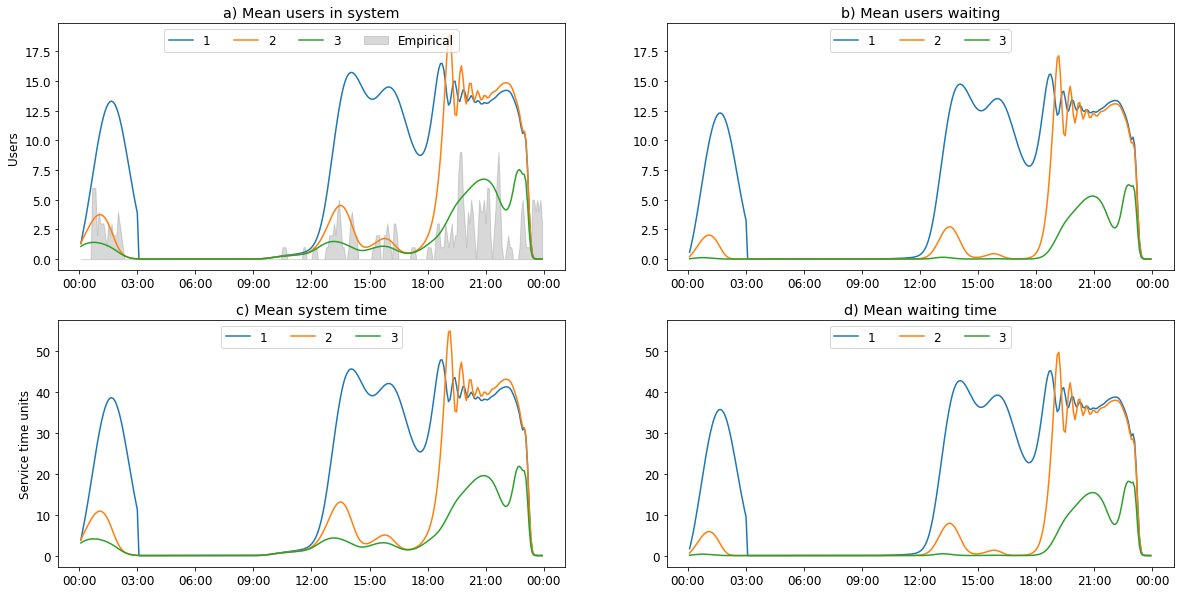

In [227]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

fmt = md.DateFormatter('%H:%M')

axs[0, 0].plot(x, L_c1, label='1')
axs[0, 0].plot(x, L_c2, label='2')
axs[0, 0].plot(x, L_c3, label='3')
axs[0, 0].fill_between(x, n_real[1:], color='gray', alpha=.3, label='Empirical')
axs[0, 0].set_title('a) Mean users in system')
axs[0, 0].set_ylabel('Users')

axs[0, 1].set_ylim(axs[0, 0].get_ylim())
axs[0, 1].plot(x, Lq_c1, label='1')
axs[0, 1].plot(x, Lq_c2, label='2')
axs[0, 1].plot(x, Lq_c3, label='3')
axs[0, 1].set_title('b) Mean users waiting')

axs[1, 0].plot(x, Ws_c1, label='1')
axs[1, 0].plot(x, Ws_c2, label='2')
axs[1, 0].plot(x, Ws_c3, label='3')
axs[1, 0].set_title('c) Mean system time')
axs[1, 0].set_ylabel('Service time units')

axs[1, 1].set_ylim(axs[1, 0].get_ylim())
axs[1, 1].plot(x, Wq_c1, label='1')
axs[1, 1].plot(x, Wq_c2, label='2')
axs[1, 1].plot(x, Wq_c3, label='3')
axs[1, 1].set_title('d) Mean waiting time')

for ax in axs.ravel(): 
    ax.xaxis.set_major_formatter(fmt)
    ax.legend(loc='upper center', ncol=4)

In [194]:
C_escala = [
    0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else
    1 if dt.datetime(2023, 1, 10, 9) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 12) else 
    2 if dt.datetime(2023, 1, 10, 12) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 18) else
    3 
    for t in T_fila]
_lamb = a_t_fila[:-1]
_theta = theta
probs_estab_escala = processo_fila(T_fila, L, C_escala, m, _lamb, k, _theta)

Text(0, 0.5, '$C_t$')

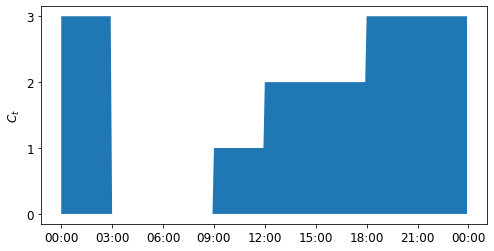

In [219]:
fig, ax = plt.subplots(figsize=(8, 4))

fmt = md.DateFormatter('%H:%M')
ax.fill_between([t0 + dt.timedelta(seconds=t * 86400) for t in T_fila], C_escala)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('$C_t$')

In [195]:
L_escala = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_escala]
Lq_escala = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_escala, C_escala)]
Wq_escala = Lq_escala / _theta / 5
Ws_escala = L_escala / _theta / 5

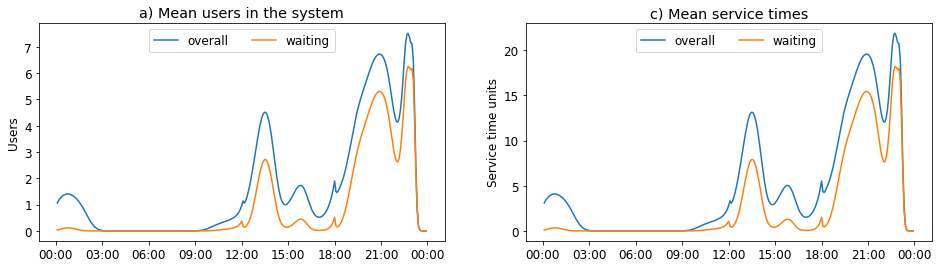

In [236]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

fmt = md.DateFormatter('%H:%M')

axs[0].plot(x, L_escala, label='overall')
axs[0].plot(x, Lq_escala, label='waiting')
axs[0].set_title('a) Mean users in the system')
axs[0].set_ylabel('Users')
axs[1].plot(x, Ws_escala, label='overall')
axs[1].plot(x, Wq_escala, label='waiting')
axs[1].set_title('c) Mean service times')
axs[1].set_ylabel('Service time units')

for ax in axs.ravel(): 
    ax.xaxis.set_major_formatter(fmt)
    ax.legend(loc='upper center', ncol=2)

In [186]:
sum([1 for l, c in zip(L_c1, C1) if l > c]) / len(T_fila)

0.5972222222222222

In [187]:
sum([1 for l, c in zip(L_c2, C2) if l > c]) / len(T_fila)

0.3472222222222222

In [188]:
sum([1 for l, c in zip(L_c3, C3) if l > c]) / len(T_fila)

0.17708333333333334

In [237]:
sum([1 for l, c in zip(L_escala, C_escala) if l > c]) / len(T_fila)

0.2465277777777778